# 0.0. IMPORTS

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from tabulate import tabulate
from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from imblearn.under_sampling import NearMiss
import warnings
warnings.filterwarnings('ignore')


# 0.1. Helper Functions

In [63]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 24

    sns.set()
    
def descriptive_num_attributes(num_attributes):
    #central tendency - mean, median
    ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

    #dispersion - std, min ,max, range, skew, kurtosis
    d1 = pd.DataFrame (num_attributes.apply(np.std)).T
    d2 = pd.DataFrame (num_attributes.apply(min)).T
    d3 = pd.DataFrame (num_attributes.apply(max)).T
    d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T # range
    d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T # skew
    d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T # kurtosis

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    return m

In [64]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Data

In [65]:
df_healthcare_raw = pd.read_csv('/Users/Igor/repos/data_glacier/final_project/healthcare_dataset.csv', low_memory=False)
pd.set_option('display.max_columns', None)
df_healthcare_raw.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


# 1.0. STEP 01 - DATA DESCRIPTION

In [66]:
df1 = df_healthcare_raw.copy()

## 1.1. Rename Columns

In [67]:
df1.columns

Index(['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Com

## 1.2. Data Dimensions

In [68]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 3424
Number of Columns: 69


## 1.3. Data Types

In [69]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.dtypes)

Ptid                                                                  object
Persistency_Flag                                                      object
Gender                                                                object
Race                                                                  object
Ethnicity                                                             object
Region                                                                object
Age_Bucket                                                            object
Ntm_Speciality                                                        object
Ntm_Specialist_Flag                                                   object
Ntm_Speciality_Bucket                                                 object
Gluco_Record_Prior_Ntm                                                object
Gluco_Record_During_Rx                                                object
Dexa_Freq_During_Rx                                                    int64

## 1.4. Check NA

In [70]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.isna().sum())

Ptid                                                                  0
Persistency_Flag                                                      0
Gender                                                                0
Race                                                                  0
Ethnicity                                                             0
Region                                                                0
Age_Bucket                                                            0
Ntm_Speciality                                                        0
Ntm_Specialist_Flag                                                   0
Ntm_Speciality_Bucket                                                 0
Gluco_Record_Prior_Ntm                                                0
Gluco_Record_During_Rx                                                0
Dexa_Freq_During_Rx                                                   0
Dexa_During_Rx                                                  

## 1.5. Descriptive Statistical

In [71]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])# select all columns by the type, in this case, numeric
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])# exclude all columns by the type, in this case, numeric

## 1.5.1 Numerical Atributes

In [72]:
descriptive_num_attributes(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Dexa_Freq_During_Rx,0.000,146.000,146.000,3.016,0.000,8.135,6.809,74.758
1,Count_Of_Risks,0.000,7.000,7.000,1.239,1.000,1.095,0.880,0.900


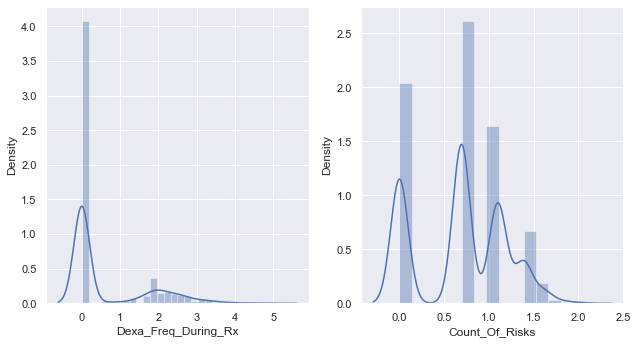

In [73]:
# Normal Distribution Check

# Dexa_Freq_During_Rx
plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['Dexa_Freq_During_Rx']));

# Count_Of_Risks
plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['Count_Of_Risks']));

## 1.5.2 Categorical Atributes

In [74]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cat_attributes.apply(lambda x: x.unique().shape[0]))

Ptid                                                                  3424
Persistency_Flag                                                         2
Gender                                                                   2
Race                                                                     4
Ethnicity                                                                3
Region                                                                   5
Age_Bucket                                                               4
Ntm_Speciality                                                          36
Ntm_Specialist_Flag                                                      2
Ntm_Speciality_Bucket                                                    3
Gluco_Record_Prior_Ntm                                                   2
Gluco_Record_During_Rx                                                   2
Dexa_During_Rx                                                           2
Frag_Frac_Prior_Ntm      

# 2.0. STEP 02 - FEATURE ENGINEERING

In [75]:
df2 = df1.copy()

## 2.1. Feature Engineering

In [76]:
# Replacing all values 'Y' (Yes) and 'N' (No) for 1 (Yes) and 0 (No), of all categorical attributes Concomitancy and Comorbidity
data = df2.iloc[:, 25:49].replace('Y', 1).replace('N', 0)

# Count_Of_Concomitancy
df2['Count_Of_Concomitancy'] = data.iloc[:, 14:24].dot(np.ones(data.iloc[:, 14:24].shape[1]))
df2['Count_Of_Concomitancy'] = df2['Count_Of_Concomitancy'].astype(np.int64)

# Count_Of_Comorbidity
df2['Count_Of_Comorbidity'] = data.iloc[:, 0:14].dot(np.ones(data.iloc[:, 0:14].shape[1]))
df2['Count_Of_Comorbidity'] = df2['Count_Of_Comorbidity'].astype(np.int64)   

df2

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,1,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,6
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,Y,Y,Y,N,Y,Y,N,N,N,Y,N,Y,Y,N,N,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,1,

In [77]:
df2.dtypes

Ptid                     object
Persistency_Flag         object
Gender                   object
Race                     object
Ethnicity                object
                          ...  
Risk_Immobilization      object
Risk_Recurring_Falls     object
Count_Of_Risks            int64
Count_Of_Concomitancy     int64
Count_Of_Comorbidity      int64
Length: 71, dtype: object

# 3.0. STEP 03 - VARIABLES FILTER

In [78]:
df3 = df2.copy()

In [79]:
df3.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,1,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,6
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,5


## 3.1. Columns Selection

In [80]:
df3[(df3['Dexa_Freq_During_Rx'] == 0) & (df3['Dexa_During_Rx'] == 'Y')].shape

(0, 71)

Because there are no values 'Y' in column 'Dexa_During_Rx' for values 0 in column 'Dexa_Freq_During_Rx', it is assumed 
that all values 0 in column 'Dexa_Freq_During_Rx' are values 'N' in column 'Dexa_During_Rx', and all values above
0 in column 'Dexa_Freq_During_Rx' are 'Y' values in column 'Dexa_During_Rx'. So there is no need to use the 
Dexa_During_Rx' column, so it can be excluded from the dataset.

In [81]:
### Business Restriction for columns:
cols_drop = ['Dexa_During_Rx'] 
df3 = df3.drop(cols_drop, axis=1)

In [82]:
df3.columns

Index(['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_Histo

In [83]:
print('Number of Rows: {}'.format(df3.shape[0]))
print('Number of Columns: {}'.format(df3.shape[1]))

Number of Rows: 3424
Number of Columns: 70


# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [84]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

Persistency_Flag
Non-Persistent    2135
Persistent        1289
dtype: int64


<AxesSubplot:xlabel='Persistency_Flag', ylabel='count'>

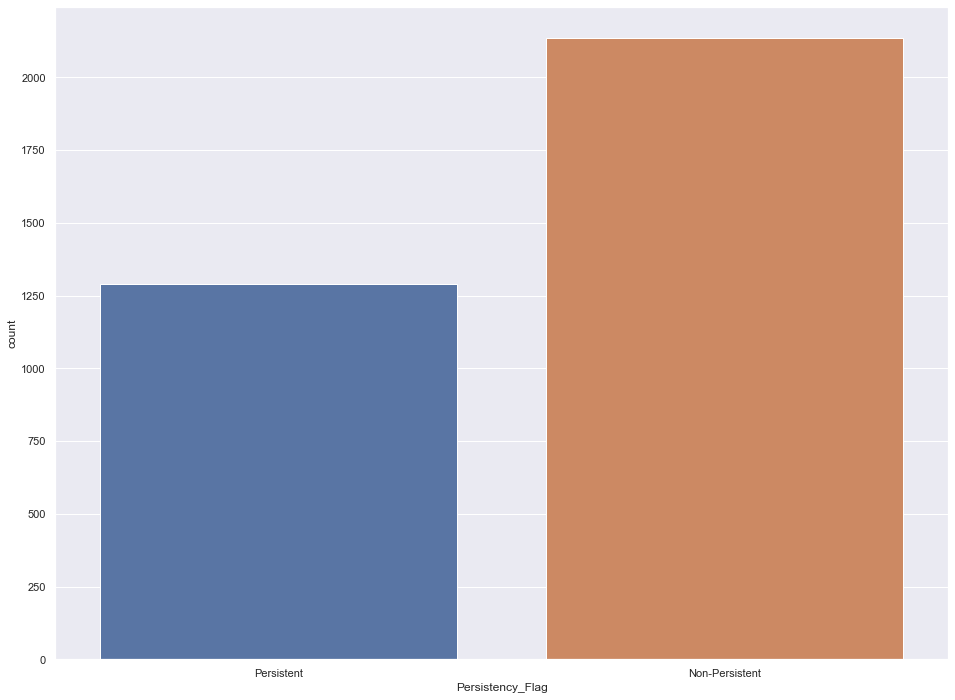

In [85]:
print(df1.value_counts('Persistency_Flag'))
sns.countplot(x="Persistency_Flag",data=df1, dodge=True)

### 4.1.2. Numerical Variable

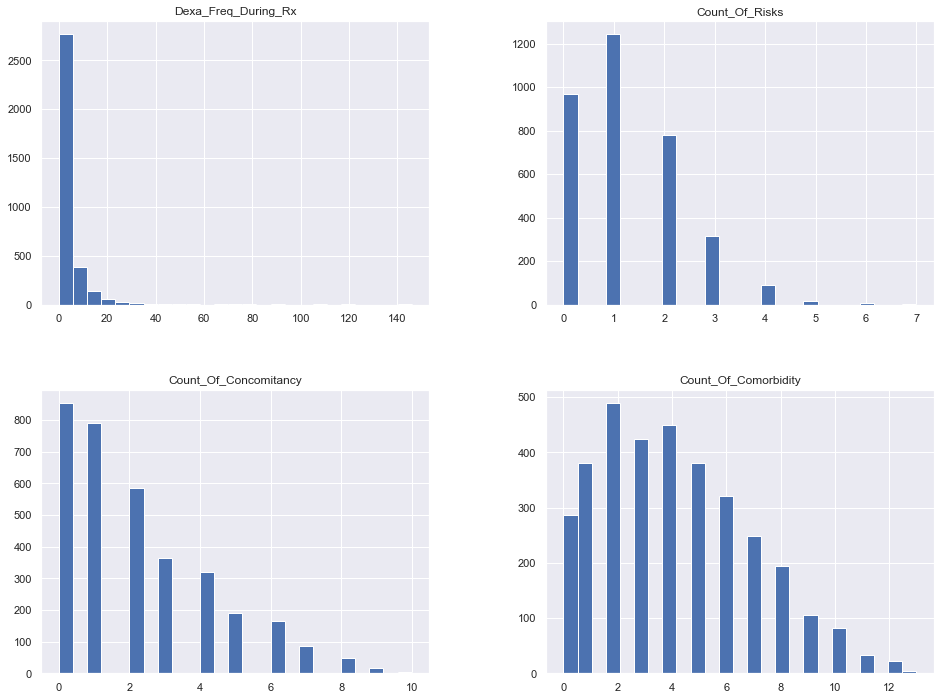

In [86]:
a = df4.select_dtypes(include=['int64', 'float64'])

a.hist(bins = 25);

All numerical attributes show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

All variables show a positive skew, trending to the left. And the variable 'Dexa_Freq_During_Rx' presents a very high kurtosis, because its values are extremely concentrated on the value 0.

### 4.1.3. Categorical Variable

The Categorical Variable will be analyzed in Bivariate Analysis, in the hypothesis tests.

# 5.0. STEP 05 - DATA PREPARATION

In [87]:
df5 = df4.copy()

## 5.1. Normalization

In [88]:
num_attributes1 = df5.select_dtypes(include=['int64','float64'])

In [89]:
num_attributes1.head()

,Dexa_Freq_During_Rx,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,0,0,0,5
1,0,0,0,1
2,0,2,1,2
3,0,1,3,6
4,0,1,3,5


In [90]:
descriptive_num_attributes(num_attributes1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Dexa_Freq_During_Rx,0.000,146.000,146.000,3.016,0.000,8.135,6.809,74.758
1,Count_Of_Risks,0.000,7.000,7.000,1.239,1.000,1.095,0.880,0.900
2,Count_Of_Concomitancy,0.000,10.000,10.000,2.175,2.000,2.094,1.010,0.389
3,Count_Of_Comorbidity,0.000,13.000,13.000,4.098,4.000,2.779,0.527,-0.325


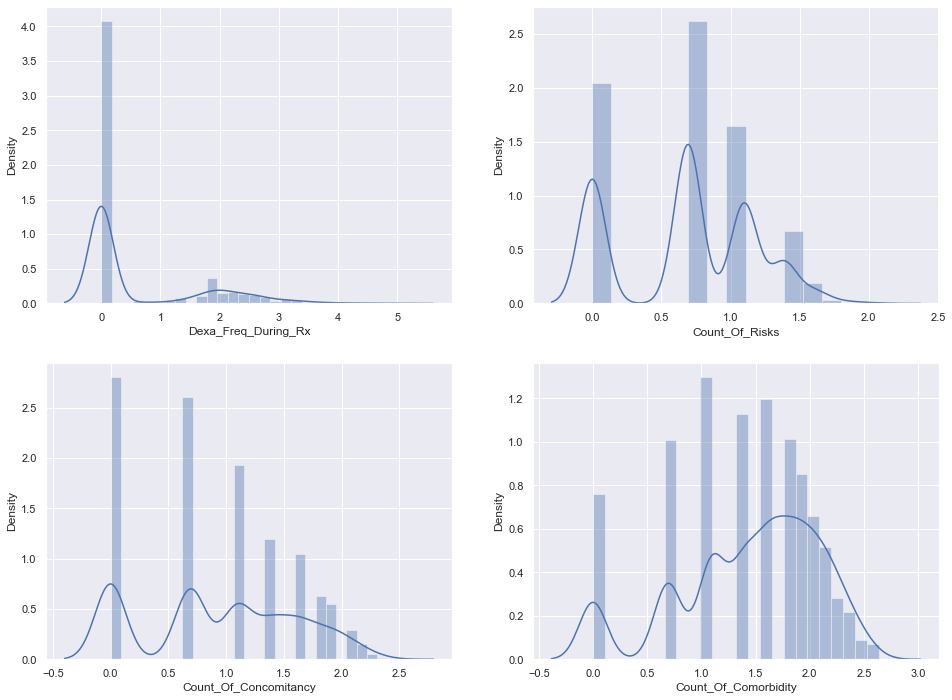

In [91]:
# Normal Distribution Check

# Dexa_Freq_During_Rx
plt.subplot(2,2,1)
sns.distplot(np.log1p(num_attributes1['Dexa_Freq_During_Rx']));

# Count_Of_Risks
plt.subplot(2,2,2)
sns.distplot(np.log1p(num_attributes1['Count_Of_Risks']));

# 	Count_Of_Concomitancys
plt.subplot(2,2,3)
sns.distplot(np.log1p(num_attributes1['Count_Of_Concomitancy']));

# Count_Of_Risks
plt.subplot(2,2,4)
sns.distplot(np.log1p(num_attributes1['Count_Of_Comorbidity']));

The range of the variable 'Dexa_Freq_During_Rx' is very different from the others variables, wich it can be influenciable on the ML model. 
To solve this it is necessery rescale the variables.

Since there are no numerical variables with normal distribution, normalization is not used then.

## 5.2. Rescaling

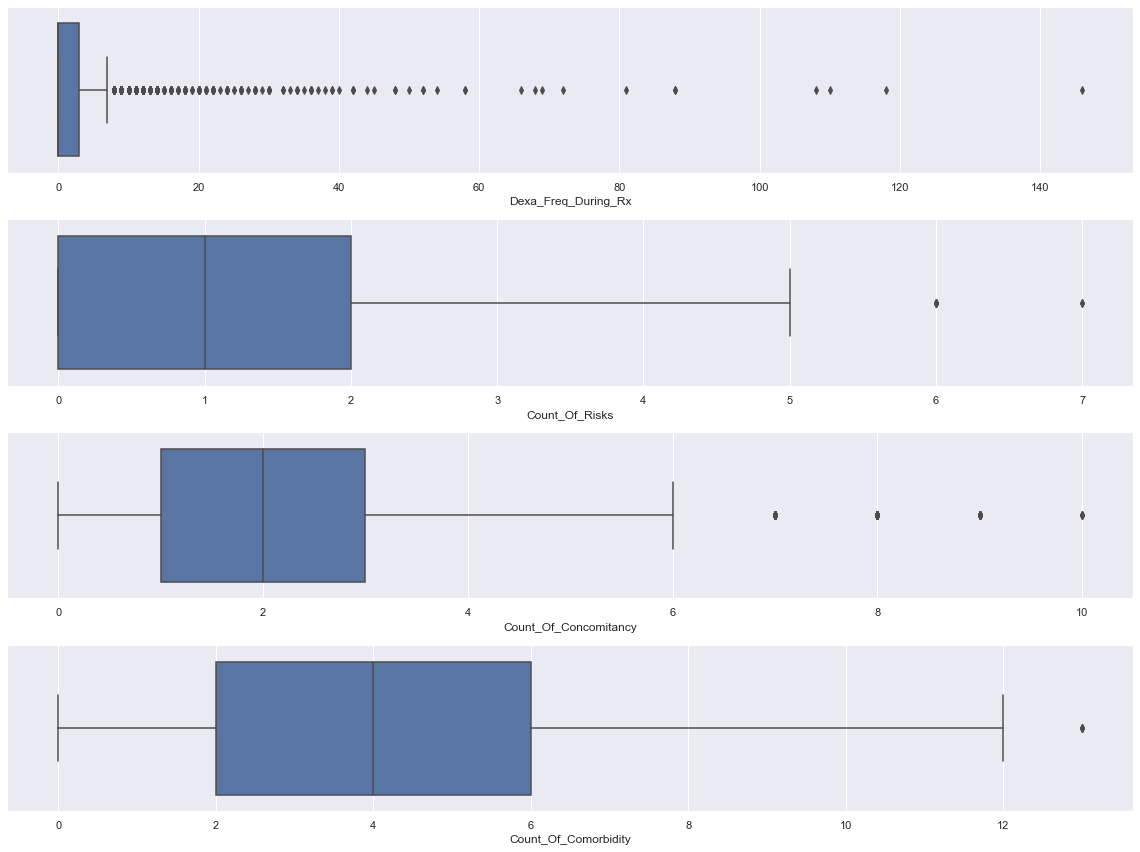

In [92]:
# Dexa_Freq_During_Rx
plt.subplot(4,1,1)
sns.boxplot(df5['Dexa_Freq_During_Rx'])
plt.tight_layout()
# use the robust scaler because it has many outliers

# Count_Of_Risks
plt.subplot(4,1,2)
sns.boxplot(df5['Count_Of_Risks'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

# Count_Of_Concomitancy
plt.subplot(4,1,3)
sns.boxplot(df5['Count_Of_Concomitancy'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

# Count_Of_Comorbidity
plt.subplot(4,1,4)
sns.boxplot(df5['Count_Of_Comorbidity'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

In [93]:
# all numerical variables with non-cyclical nature
rs = RobustScaler()
mms = MinMaxScaler()

# Dexa_Freq_During_Rx uses Robust Scaler
df5['Dexa_Freq_During_Rx'] = rs.fit_transform(df5[['Dexa_Freq_During_Rx']].values)
#pickle.dump(rs, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/competition_distance_scaler.pkl', 'wb'))

# Count_Of_Risks uses uses Min-Max Scaler
df5['Count_Of_Risks'] = mms.fit_transform(df5[['Count_Of_Risks']].values)
#pickle.dump(rs, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/competition_time_month_scaler.pkl', 'wb'))

# Count_Of_Concomitancy uses Min-Max Scaler
df5['Count_Of_Concomitancy'] = mms.fit_transform(df5[['Count_Of_Concomitancy']].values)
#pickle.dump(mms, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/promo_time_week_scaler.pkl', 'wb'))

# Count_Of_Comorbidity uses Min-Max Scaler
df5['Count_Of_Comorbidity'] = mms.fit_transform(df5[['Count_Of_Comorbidity']].values)
#pickle.dump(mms, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/year_scaler.pkl', 'wb'))

## 5.3. TRansformation

### 5.3.1. Encoding

In [94]:
b = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [95]:
# Categorical Variables

# Categorical attributes that presents binary values as 'Y' and 'N', the method Label Encoding will be used in order to
# transfoer 'Y' and 'N' values into 1 and 0 respectively.

df5 = df5.replace('Y', 1).replace('N', 0)


# Categorical attributes that presents binary values also will be use the method  Label Encoding
le = LabelEncoder()

# Persistency_Flag (Persistent = 1, Non-Persistent = 0)
df5['Persistency_Flag'] = le.fit_transform(df5['Persistency_Flag'])

# Gender (Male = 1, Female = 0)
df5['Gender'] = le.fit_transform(df5['Gender'])

# Ntm_Specialist_Flag (Specialist = 1, Others = 0)
df5['Ntm_Specialist_Flag'] = le.fit_transform(df5['Ntm_Specialist_Flag'])

# Risk_Segment_Prior_Ntm (VLR_LR = 1, HR_VHR = 0)
df5['Risk_Segment_Prior_Ntm'] = le.fit_transform(df5['Risk_Segment_Prior_Ntm'])

# Adherent_Flag (Non-Adherent = 1, Adherent = 0)
df5['Adherent_Flag'] = le.fit_transform(df5['Adherent_Flag'])


# Categorical attributes that presents order or scale will be use the method  Ordinal Encoding

# Age_Bucket
Age_Bucket_dict = {'<55' : 1, '55-65' : 2, '65-75' : 3, '>75' : 4}
df5['Age_Bucket'] = df5['Age_Bucket'].map(Age_Bucket_dict)

# Tscore_Bucket_Prior_Ntm (>-2.5 = 1, <=-2.5 = 0)
Tscore_Bucket_Prior_Ntm_dict = {'<=-2.5' : 1, '>-2.5' : 2}
df5['Tscore_Bucket_Prior_Ntm'] = df5['Tscore_Bucket_Prior_Ntm'].map(Tscore_Bucket_Prior_Ntm_dict)


# Categorical attributes that do not presents order or scale or idea os state, each value is independent, 
# will be use the method  Label Encoding

# Race
df5['Race'] = le.fit_transform(df5['Race'])

# Ethnicity
df5['Ethnicity'] = le.fit_transform(df5['Ethnicity'])

# Region
df5['Region'] = le.fit_transform(df5['Region'])

# Ntm_Speciality_Bucket
df5['Ntm_Speciality_Bucket'] = le.fit_transform(df5['Ntm_Speciality_Bucket'])

# Risk_Segment_During_Rx
df5['Risk_Segment_During_Rx'] = le.fit_transform(df5['Risk_Segment_During_Rx'])

# Tscore_Bucket_During_Rx
df5['Tscore_Bucket_During_Rx'] = le.fit_transform(df5['Tscore_Bucket_During_Rx'])


# Categorical attributes that presents an idea os state, will be use the method  One Hot Encoding

# Change_T_Score
df5 = pd.get_dummies(df5,prefix=['Change_T_Score'], columns=['Change_T_Score'])

# Change_Risk_Segment
df5 = pd.get_dummies(df5,prefix=['Change_Risk_Segment'], columns=['Change_Risk_Segment'])


# Categorical attributes that presents a huge amount of values, will be use the method  Target Encoding
encoder = TargetEncoder()

# Ntm_Speciality
df5['Ntm_Speciality_Encoded'] = encoder.fit_transform(df5['Ntm_Speciality'], df5['Persistency_Flag'])

In [96]:
df5.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Unknown,Change_T_Score_Worsened,Change_Risk_Segment_Improved,Change_Risk_Segment_No change,Change_Risk_Segment_Unknown,Change_Risk_Segment_Worsened,Ntm_Speciality_Encoded
0,P1,1,1,2,1,4,4,GENERAL PRACTITIONER,0,1,0,0,0.000,0,0,1,2,2,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.385,0,1,0,0,0,0,1,0,0.322
1,P2,0,1,1,1,4,2,GENERAL PRACTITIONER,0,1,0,0,0.000,0,0,1,2,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.077,0,0,1,0,0,0,1,0,0.322
2,P3,0,0,3,0,0,3,GENERAL PRACTITIONER,0,1,0,0,0.000,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.286,0.100,0.154,0,1,0,0,0,1,0,0,0.322
3,P4,0,0,2,1,0,4,GENERAL PRACTITIONER,0,1,0,1,0.000,0,0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.462,0,1,0,0,0,1,0,0,0.322
4,P5,0,0,2,1,0,4,GENERAL PRACTITIONER,0,1,1,1,0.000,0,0,0,1,1,2,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.385,0,0,1,0,0,0,1,0,0.322


# 6.0. STEP 06 - FEATURE SELECTION

In [97]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset

In [98]:
# first delete original variables that originated derived variables, they are deleted because they contain the same information
# as the derivatives.

# Attributes to exclude after encoding
cols_drop = ['Ptid', 'Ntm_Speciality']
df6 = df6.drop(cols_drop, axis=1)

In [99]:
# split training and test
X = df6.drop(columns = 'Persistency_Flag', axis = 1)
Y = df6['Persistency_Flag']

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [100]:
df7 = df6.copy()
df7

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Unknown,Change_T_Score_Worsened,Change_Risk_Segment_Improved,Change_Risk_Segment_No change,Change_Risk_Segment_Unknown,Change_Risk_Segment_Worsened,Ntm_Speciality_Encoded
0,1,1,2,1,4,4,0,1,0,0,0.000,0,0,1,2,2,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.385,0,1,0,0,0,0,1,0,0.322
1,0,1,1,1,4,2,0,1,0,0,0.000,0,0,1,2,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.077,0,0,1,0,0,0,1,0,0.322
2,0,0,3,0,0,3,0,1,0,0,0.000,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.286,0.100,0.154,0,1,0,0,0,1,0,0,0.322
3,0,0,2,1,0,4,0,1,0,1,0.000,0,0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.462,0,1,0,0,0,1,0,0,0.322
4,0,0,2,1,0,4,0,1,1,1,0.000,0,0,0,1,1,2,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.385,0,0,1,0,0,0,1,0,0.322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,1,0,2,1,3,4,0,1,0,0,0.000,0,0,1,2,1,2,0,1,1,1,0,1,1,0,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.143,0.500,0.538,0,0,1,0,0,0,1,0,0.322
3420,1,0,2,1,3,4,0,1,0,0,0.000,0,0,0,1,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.200,0.000,0,0,1,0,0,0,1,0,0.313
3421,1,0,2,1,3,4,1,0,0,0,2.333,0,0,1,2,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.143,0.300,0.308,0,1,0,0,0,0,0,1,0.496
3422,0,0,2,1,3,2,0,1,0,0,0.000,0,1,1,2,1,2,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0

In [101]:
df7.value_counts('Persistency_Flag')

Persistency_Flag
0    2135
1    1289
dtype: int64

### 7.0.1 Spliting Dataset into Target Variablen (y) and Features (X)

In [102]:
# target variable and features split 
X = df7.drop(columns = 'Persistency_Flag', axis = 1)
y = df7['Persistency_Flag']

In [103]:
# Numer of rows before dataset balanced
print(X.shape, end='\n\n')
print(y.shape)

(3424, 74)

(3424,)


In [104]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' before dataset balanced
np.bincount(y)

array([2135, 1289], dtype=int64)

### 7.0.2 Balancing Dataset

In [105]:
nr = NearMiss()

In [106]:
X, y = nr.fit_resample(X, y)

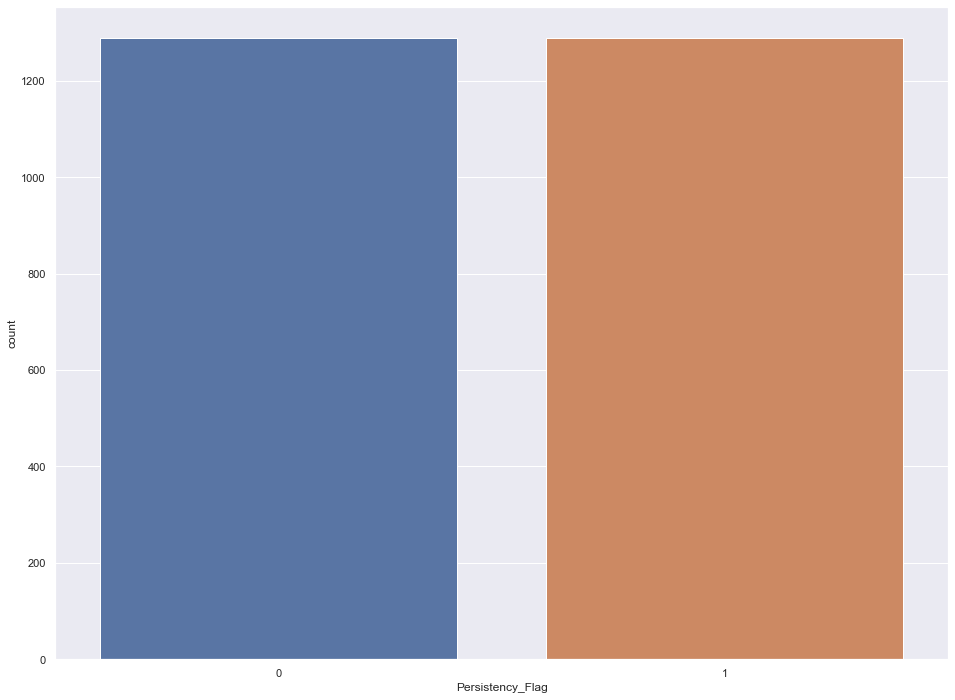

In [107]:
ax = sns.countplot(x=y)

In [108]:
# Numer of rows after dataset balanced
print(X.shape, end='\n\n')
print(y.shape)

(2578, 74)

(2578,)


In [109]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced
np.bincount(y)

array([1289, 1289], dtype=int64)